# Bots and Brexit Network Analysis Project

7CUSMDNA 1887975 Feb 2018

Twitter data provided by Pushkal Agarwal

Created in Python 3.6

In [1]:
import networkx as nx
import pandas as pd
import re
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import collections
import statistics
%matplotlib inline

## Read in tweets, extract hashtags and join with botometer scores

In [24]:
#Read in tweet data
tweet_data = pd.read_csv("data/brexittweetsmaster.csv")

#Read in bot scores
BotScore = pd.read_csv("data/BotScore73KUsers.csv")

#Change column names for consistency
BotScore.columns = ["screenName", "Score"]

#Merge frames to add bot liklihood to main dataframe
tweets_scored = pd.merge(tweet_data, BotScore, on="screenName", how = "left")

#Extract list of hashtags, ignore non alphanumeric characters
#These include .,: and are probably there by accident
tweets_scored['hashtags'] = tweets_scored.text.str.findall(r'#[a-zA-Z0-9][a-zA-Z0-9]*?(?=[^a-zA-Z0-9]|\s|$)')

print("Number of tweets: " + str(len(tweets_scored)))

Number of tweets: 1048575


## Define bot theshold with botometer score

Number of bot accouts: 55318
Number of human accounts: 964316
Number of bot tweets: 55318
Number of human tweets: 964316
Proportion Bot: 0.054252800514694485
Proportion human: 0.9457471994853055


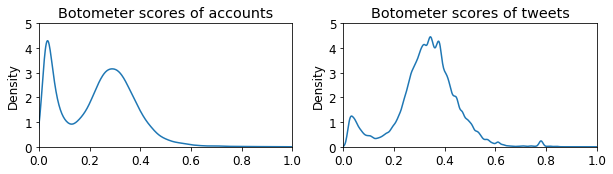

In [25]:
#Define bot theshold
threshold = 0.5

#Create subsets
bot_tweets = tweets_scored.loc[tweets_scored["Score"] > threshold]
human_tweets = tweets_scored.loc[tweets_scored["Score"] <= threshold]

#Count number of bot and human tweets
print("Number of bot accouts: " + str(len(bot_tweets.screenName)))
print("Number of human accounts: " + str(len(human_tweets.screenName)))

bot_no =  len(bot_tweets)
hum_no = len(human_tweets)
    
#Count number of bot and human accounts
print("Number of bot tweets: " + str(bot_no))
print("Number of human tweets: " + str(hum_no))
print("Proportion Bot: " + str(bot_no/(bot_no+hum_no)))
print("Proportion human: " + str(hum_no/(bot_no+hum_no)))

#Plot distribution of account and tweet scores
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(221)
BotScore.plot.kde(ax=ax1, legend=False, title='Botometer scores of accounts')

ax2 = fig.add_subplot(222)
tweets_scored.Score.plot.kde(ax=ax2, legend=False, title='Botometer scores of tweets')

ax1.set(xlim=[0,1], ylim=[0,5])
ax2.set(xlim=[0,1], ylim=[0,5])

fig.show()

fig.savefig("Botometer_scores.jpg")

## Define function to create list of  tuples with node pairs and weight

In [26]:
#find unique common occurances of tweets
def tweets2hashtag_pairs(tweet_frame): 
    unique_hash = pd.DataFrame(tweet_frame.hashtags.apply(sorted)
                               .transform(tuple).value_counts()).reset_index()

    #rename columns
    unique_hash.columns = ["Hashtags", "Frequency"]

    #Create list with tuples of hashtag combinations (any number) and frequency
    ulist = list(zip(unique_hash["Hashtags"], unique_hash["Frequency"]))
    
    #Create list with tuples of hashtag combinations (pairs) and frequency
    hpairs0 = []
    for x in range(len(ulist)):
        for comb in combinations(ulist[x][0], 2):
            hpairs0.append([comb,ulist[x][1]])

    #Convert hashtag pair list to dataframe sort by frequency and reset index         
    hpairs = pd.DataFrame(hpairs0).groupby(0).sum().sort_values(1, ascending = False).reset_index()
    hpairs.columns = ["Hash Pair", "freq"]

    #Unzip the tuples (by first converting to lists)
    #The result is a list for each node within the edges (hashtag pair)
    sep_nodes = list(zip(*list(hpairs.loc[:,"Hash Pair"])))

    #Use lists to create columns in new dataframe corresponding to each node in edge 
    hpairs["Hash1"] = sep_nodes[0]
    hpairs["Hash2"]= sep_nodes[1]

    #Make all lower case (cannot do this earlier as need to be string pairs)
    hpairs["Hash1"] = hpairs["Hash1"].str.lower()
    hpairs["Hash2"] = hpairs["Hash2"].str.lower()
    hpairs = hpairs.groupby(["Hash1","Hash2"]).sum().sort_values("freq", ascending = False).reset_index()

    #Create list of tuples for use in networkx (hash1, hash2, weight(number of edges))
    for_nx = list(zip(hpairs["Hash1"], hpairs["Hash2"], hpairs["freq"]))
    
    return for_nx

## Create graphs

In [27]:
#Run tweets2hashtag_pairs function for bot and human tweets
bot_nx = tweets2hashtag_pairs(bot_tweets)
hum_nx = tweets2hashtag_pairs(human_tweets)

#Create bot graph
BotL=nx.Graph(name="Bot graph")
BotL.add_weighted_edges_from(bot_nx)

#Create human graph
HumL=nx.Graph(name= "Human graph")
HumL.add_weighted_edges_from(hum_nx)

## Network structure

In [40]:
#Calculate average weighted degree Bot
def network_struct(GRAPH):

    deg_weight = dict(GRAPH.degree(weight="weight"))
    deg_weight_list = [deg_weight[key] for key in deg_weight]
    deg_mean = statistics.mean(deg_weight_list)
    
    dc = nx.degree_centrality(GRAPH)
    dc_list = [dc[key] for key in dc]
    dc_mean = statistics.mean(dc_list)
    
    wei = np.array(list(nx.get_edge_attributes(GRAPH, "weight").values())).sum()

    #Summary info bot graph
    print(nx.info(GRAPH))
    print("Average weighted degree: " + str(deg_mean))
    print("Average degree centrality: " + str(dc_mean))
    print("Density: " + str(nx.density(GRAPH)))
    print("Transitivity: " + str(nx.transitivity(GRAPH)))
    print("Average clustering coefficient: " + str(nx.average_clustering(GRAPH)))
    print("Total weight of edges: "+ str(wei))   

In [29]:
network_struct(BotL)

Name: Bot graph
Type: Graph
Number of nodes: 3844
Number of edges: 13882
Average degree:   7.2227
Average weighted degree: 24.644640998959417
Average degree centrality: 0.0018794391630064854
Density: 0.0018794391630064854
Transitivity: 0.012211770955236552
Average clustering coefficient: 0.6795979978154237
Total weight of edges: 47367


In [ ]:
network_struct(HumL)

Name: Human graph
Type: Graph
Number of nodes: 21182
Number of edges: 98672
Average degree:   9.3166
Average weighted degree: 48.74978755547163
Average degree centrality: 0.0004398559821146869
Density: 0.0004398559821146869


## Degree distribution

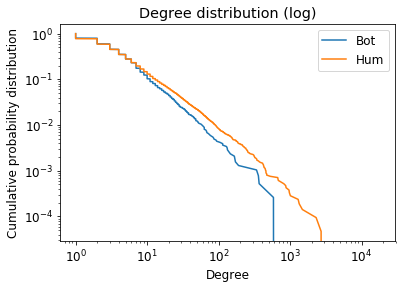

In [31]:
#Create figure
fig8 = plt.figure()
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12) 

#Create subplot
ax10 = fig8.add_subplot(111)

#Extract diciontaries with weights
Bot_dict = dict(nx.degree(BotL, weight="Weight"))
Hum_dict = dict(nx.degree(HumL, weight="Weight"))

#Create dataframe with degrees
Bot_df =pd.DataFrame([list(Bot_dict.values())]).iloc[0,:]

#Sort
bot_sorted = np.sort(Bot_df)

#Calculate cumulative probability
botyvals= np.ones(len(bot_sorted)) - np.arange(len(bot_sorted))/float(len(bot_sorted)-1)

#Repeat for human
Hum_df =pd.DataFrame([list(Hum_dict.values())]).iloc[0,:]
hum_sorted = np.sort(Hum_df)
humyvals= np.ones(len(hum_sorted)) - np.arange(len(hum_sorted))/float(len(hum_sorted)-1)

#Plot both
ax10.plot(bot_sorted,botyvals, label="Bot")
ax10.plot(hum_sorted,humyvals, label="Hum")
ax10.set(title="Degree distribution (log)", xlabel ='Degree', 
         ylabel='Cumulative probability distribution', xscale = 'log', yscale = 'log')
ax10.legend()

plt.savefig("Deg_dist.jpg", bbox_inches='tight', facecolor="white")
plt.show()

## Viz top 100 nodes for Gephi

In [32]:
#Create graph
bot_top_100 = pd.DataFrame.from_dict(dict(BotL.degree(weight="weight")), orient="index").head(100).index.tolist()
hum_top_100 = pd.DataFrame.from_dict(dict(HumL.degree(weight="weight")), orient="index").head(100).index.tolist()

BotS = BotL.subgraph(bot_top_100)
HumS = HumL.subgraph(hum_top_100)

#Export for Gephi
nx.write_gexf(BotS, "BotG.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')
nx.write_gexf(HumS, "HumG.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

## Viz top 100 nodes for Gephi

In [33]:
#Create graph
BotS2=BotS.copy()
HumS2=HumS.copy()

#remove brexit node
BotS2.remove_node("#brexit")
HumS2.remove_node("#brexit")

#Export for Gephi
nx.write_gexf(BotS2, "BotG2.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')
nx.write_gexf(HumS2, "HumG2.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

## Intersection between bot and human networks

In [34]:
#Common nodes
Botcomp=BotL.copy()
Botcomp.remove_nodes_from(n for n in BotL if n not in HumL)
Humcomp=HumL.copy()
Humcomp.remove_nodes_from(m for m in HumL if m not in BotL)

R2 = nx.intersection(Botcomp, Humcomp)
print(nx.info(R2))

Name: Bot graph
Type: Graph
Number of nodes: 3294
Number of edges: 10421
Average degree:   6.3273


## Bipartite graph with bot accounts and hashtags

In [35]:
#Create filtered data frame with twitter handle and hashtags used
bot_bip = bot_tweets.filter(["screenName", "hashtags"])

#Group by twitter handle (and cominbing lists of hashtags)
bot_bip2= bot_bip.groupby(["screenName"]).sum()
bot_bip2 = bot_bip2.reset_index()

#List with screen name and hashtags used
bot_bip_list = list(zip(bot_bip2["screenName"], bot_bip2["hashtags"]))

#New list of lists with twitter handle and single hashtag
bot_bip_pairs = []
for i in range(len(bot_bip_list)): #for every element in big list
    for j in range(len(bot_bip_list[i][1])): #for every element in the sub list
        bot_bip_pairs.append([bot_bip_list[i][0], bot_bip_list[i][1][j]])

#Above as data frame       
df = pd.DataFrame([list(zip(*bot_bip_pairs))[0], list(zip(*bot_bip_pairs))[1]]) .transpose()
df.columns = ["screenName", "hashtag"]
df = df.set_index(["screenName", "hashtag"])

#Add new frequency column       
df["frequency"] = 1

#Use group by to get get frequencies      
df = df.groupby(["screenName","hashtag"]).sum().reset_index()

#Above as list of lists
listq = list(zip(df["screenName"], df["hashtag"], df["frequency"]))

#Unique accounts
bot_accounts = set(list(zip(*bot_bip_pairs))[0])

#Unique hashtags
bot_hash = set(list(zip(*bot_bip_pairs))[1])

#Create graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(bot_accounts, bipartite=0)
B.add_nodes_from(bot_hash, bipartite=1)

# Add edges only between nodes of opposite node sets
B.add_weighted_edges_from(listq)

#Create new dataframe with weights
df1 = pd.DataFrame(nx.degree(B, weight="weight")).sort_values(by=1, ascending=False)

#Take top 50 nodes
listy = df1.iloc[0:50,0].tolist()

#Create graph
B1 = B.subgraph(listy)

#Export for gephi
nx.write_gexf(B1, "bipartite.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

In [36]:
df.sort_values("frequency", ascending=False).head(20)

,screenName,hashtag,frequency
13501,brexit_politics,#Brexit,4590
13559,brexit_politics,#Politics,2709
13552,brexit_politics,#News,2331
16893,jgraddon,#Brexit,877
10052,Samillian1968,#Brexit,750
17475,keesfiere485,#Brexit,739
5695,Jpsw8,#Brexit,723
14938,didierdelmer,#Brexit,629
11367,TerryEnga,#Brexit,605
6048,KevinSharpe59,#Brexit,587


## Properties of top 20 nodes by weighted degree

In [37]:
def top_20_chara(GRAPH):
    
    cc = nx.clustering(GRAPH)
    degs = dict(GRAPH.degree())
    
    #Create data frame of weighted degrees
    top_20_nodes = pd.DataFrame(GRAPH.degree(weight="weight")).sort_values(1, ascending=False)
    top_20_nodes.columns = ["hashtag", "Weighted degree"]
    #Subset top 20 nodes
    top_20_nodes = top_20_nodes.head(20).reset_index(drop=True)

    #Create new columns for additional attributes
    top_20_nodes["Degree"] = np.nan
    top_20_nodes["Clustering"] = np.nan

    #Iterate over rows to fill dataframe with additional attributes
    for index, row in top_20_nodes.iterrows():
        top_20_nodes.iloc[index, 2] = degs.get(top_20_nodes.iloc[index, 0])
        top_20_nodes.iloc[index, 3] = cc.get(top_20_nodes.iloc[index, 0])
    top_20_nodes.index += 1
    return top_20_nodes

In [38]:
top_20_chara(BotL)

,hashtag,Weighted degree,Degree,Clustering
1,#brexit,19000,3516.0,0.001522
2,#politics,4772,48.0,0.185284
3,#news,2438,52.0,0.138763
4,#stopbrexit,2310,360.0,0.036681
5,#eu,1999,585.0,0.019239
6,#fbpe,1845,339.0,0.035979
7,#ft,944,2.0,1.000000
8,#uk,941,369.0,0.029288
9,#theresamay,914,190.0,0.067279
10,#ukip,893,133.0,0.086238


In [39]:
top_20_chara(HumL)

,hashtag,Weighted degree,Degree,Clustering
1,#brexit,172125,18107.0,0.000440
2,#stopbrexit,23754,1341.0,0.019554
3,#eu,22548,2715.0,0.008488
4,#fbpe,20585,1485.0,0.017252
5,#ukip,13454,671.0,0.046790
6,#uk,10137,2311.0,0.010066
7,#theresamay,9559,977.0,0.030898
8,#remain,7479,879.0,0.033827
9,#farageonlbc,7359,145.0,0.164655
10,#brexitshambles,6863,1010.0,0.026927
